Each column of A represents measurements taken from a patient. 

There are 216 columns representing 216 patients, out of which 121 have ovarian cancer. 

Each row represents the concentration of a different protein in
the genomic signature of the patient.

In [80]:
# !wget https://www.dropbox.com/s/bal044f83ezxiia/ovariancancer_obs.csv
# !wget https://www.dropbox.com/s/r52sn5gmkd3y797/ovariancancer_grp.csv

In [81]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

ovariancancer_obs_path = "./ovariancancer_obs.csv"
ovariancancer_grp_path = "./ovariancancer_grp.csv"

A = np.genfromtxt(ovariancancer_obs_path, delimiter=",").transpose()
f = open(ovariancancer_grp_path)
grp = np.array(f.read().split("\n"))
grp = grp[grp != ""]
n_features = A.shape[0]
n_patients = A.shape[1]
print("%d features" % n_features)
print("%d patients" % n_patients)

random_seed = 0

4000 features
216 patients


- 1: Implement the randomized SVD

In [82]:
def randomized_SVD(A, k):
    np.random.seed(random_seed)
    # print("k = ", k)
    m, n = A.shape
    # print(f"Shape of matrix A: m = {m}, n = {n}")

    # create a random matrix
    omega = np.random.rand(n, k)
    # print(f"shape of matrix Omega: ", omega.shape)
    Y = A @ omega
    # print("shape of matrix Y = A @ Omega (should be m * k): ", Y.shape)
    # default mode of qr factorization: reduced --> that's what I'm interested in
    Q, R = np.linalg.qr(Y)
    # print("Shape of matrix Q: ", Q.shape)
    B = Q.T @ A
    # print("Shape of matrix B: ", B.shape)

    # perform the SVD on B
    rU, rs, rVT = np.linalg.svd(B, full_matrices=False)

    # recover left singular values
    rU = Q @ rU

    # print("Shape of matrix rU: ", rU.shape)
    # print("Shape of vector rs: ", rs.shape)
    # print("Shape of matrix rVT: ", rVT.shape)
    return rU, rs, rVT

Text(0.5, 1.0, 'explained variance')

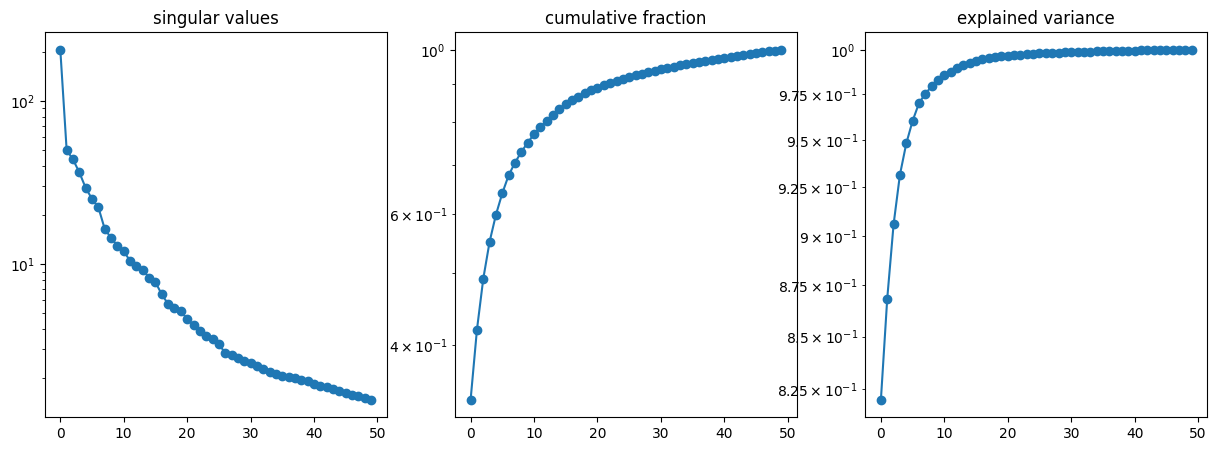

In [83]:
# First center the data
A_mean = np.mean(A, axis=1)
A_bar = A - A_mean[:, np.newaxis]

rU, rs, rVT = randomized_SVD(A_bar, 50)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].semilogy(rs, "o-")
axs[0].set_title("singular values")
axs[1].semilogy(np.cumsum(rs) / np.sum(rs), "o-")
axs[1].set_title("cumulative fraction")
axs[2].semilogy(np.cumsum(rs**2) / np.sum(rs**2), "o-")
axs[2].set_title("explained variance")

- 2: Perform the PCA on the data, using the exact SVD algorithm.

    Then plot the trend of the singular values.

Text(0.5, 1.0, 'explained variance')

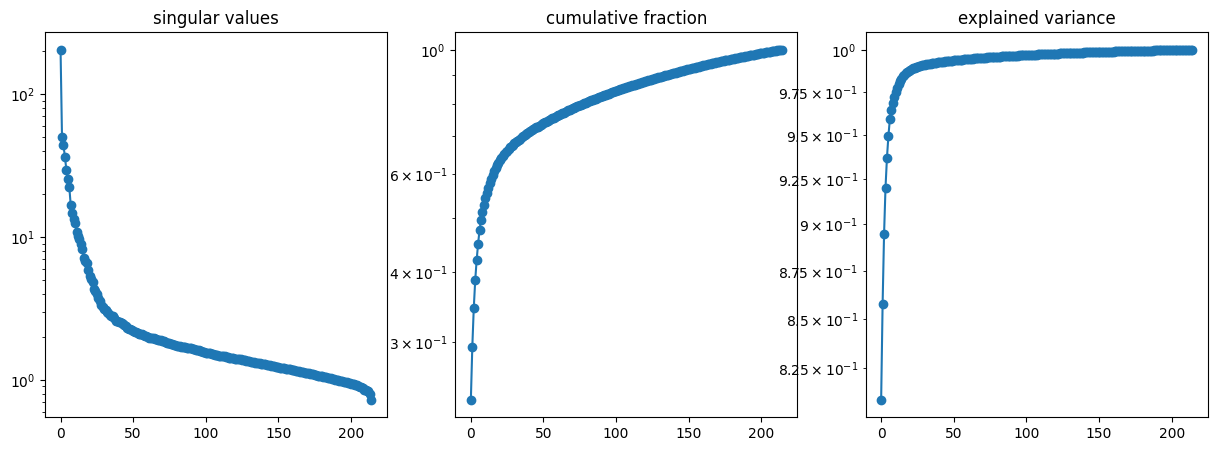

In [84]:
U, s, VT = np.linalg.svd(A_bar, full_matrices=False)

s = s[:-1]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].semilogy(s, "o-")
axs[0].set_title("singular values")
axs[1].semilogy(np.cumsum(s) / np.sum(s), "o-")
axs[1].set_title("cumulative fraction")
axs[2].semilogy(np.cumsum(s**2) / np.sum(s**2), "o-")
axs[2].set_title("explained variance")

Now, repeat the computation by considering the randomized SVD algorithm of rank $k = 1, 5, 10, 50$ and $100$.

Plot the approximate singular values together with the exact singular values.

Comment what you see.

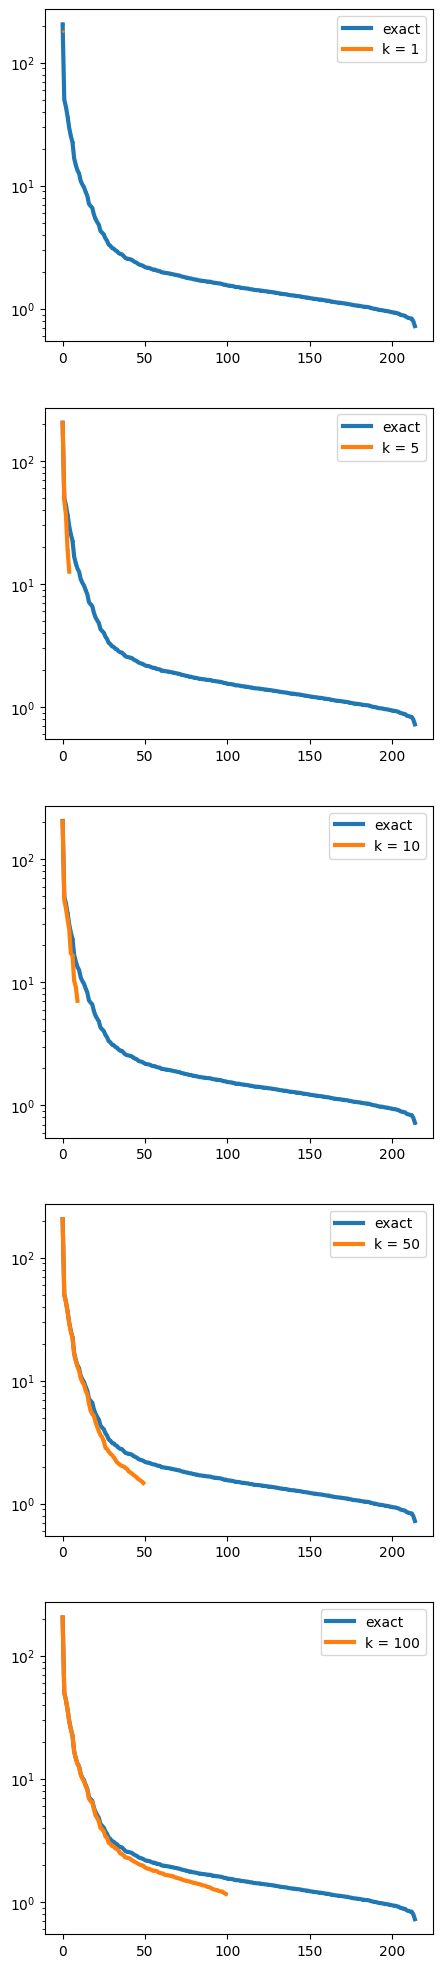

In [85]:
ks = np.array([1, 5, 10, 50, 100])

rs_array = list()

for k in ks:
    _, rs, _ = randomized_SVD(A_bar, k)
    rs_array.append(rs)

fig, axs = plt.subplots(len(ks), 1, figsize=(5, 5 * len(ks)))

i = 0
for rs in rs_array:
    axs[i].plot(s, "o-", label="exact", linewidth=3, markersize=1)
    axs[i].semilogy(rs, "o-", label="k = %d" % ks[i], linewidth=3, markersize=1)
    axs[i].legend()
    i += 1

We can see that as the rank k of the randomized SVD algorithm increases, the approximation of the singular values becomes more and more accurate.

There is an overall underestimation of the singular values (i.e. less variability is captured), but the approximation is still very good.

- 3: Use PCA (with exact SVD) to perform dimensionality reduction on the dataset for rank $k = 1, 5, 10, 50$ and $100$. 

    Compute the reconstruction error of the dataset as a function of k. 

    Repeat the same exercise by using the randomized SVD algorithm. 
    
    Repeat the same exercise by using the randomized SVD algorithm with a +50% oversampling, that is by increasing by 50% the number of columns in the matrix random P (round the quantity 1.5 k to the closest integer). 
    
    Finally, plot the trend of the reconstruction error of the dataset as a function of k in the three cases. Comment on the results.

Exact SVD:

In [86]:
# Exact SVD
U, s, VT = np.linalg.svd(A_bar, full_matrices=False)

reconstruction_error = list()

for k in ks:
    A_k = U[:, :k] @ np.diag(s[:k]) @ VT[:k, :]
    reconstruction_error.append(np.linalg.norm(A_bar - A_k, ord=2))

Randomized SVD:

In [87]:
# Randomized SVD
reconstruction_error_rand = list()

for k in ks:
    rU, rs, rVT = randomized_SVD(A_bar, k)
    A_k = rU @ np.diag(rs) @ rVT
    reconstruction_error_rand.append(np.linalg.norm(A_bar - A_k, ord=2))

Randomized SVD with oversampling:

In [88]:
def randomized_SVD_oversampling(A, k):
    np.random.seed(random_seed)
    # print("k = ", k)
    m, n = A.shape
    # print(f"Shape of matrix A: m = {m}, n = {n}")

    # create a random matrix
    omega = np.random.rand(n, round(k * 1.5))
    # print(f"shape of matrix Omega: ", omega.shape)
    Y = A @ omega
    # print("shape of matrix Y = A @ Omega (should be m * k): ", Y.shape)
    # default mode of qr factorization: reduced --> that's what I'm interested in
    Q, R = np.linalg.qr(Y)
    # print("Shape of matrix Q: ", Q.shape)
    B = Q.T @ A
    # print("Shape of matrix B: ", B.shape)

    # perform the SVD on B
    rU, rs, rVT = np.linalg.svd(B, full_matrices=False)

    # recover left singular values
    rU = Q @ rU

    # print("Shape of matrix rU: ", rU.shape)
    # print("Shape of vector rs: ", rs.shape)
    # print("Shape of matrix rVT: ", rVT.shape)
    return rU, rs, rVT

In [89]:
# Randomized SVD with oversampling
reconstruction_error_rand_oversampling = list()

for k in ks:
    rU, rs, rVT = randomized_SVD_oversampling(A_bar, k)
    A_k = rU @ np.diag(rs) @ rVT
    reconstruction_error_rand_oversampling.append(np.linalg.norm(A_bar - A_k, ord=2))

Plot the trend of the reconstruction error of the dataset as a function of k in the three cases.

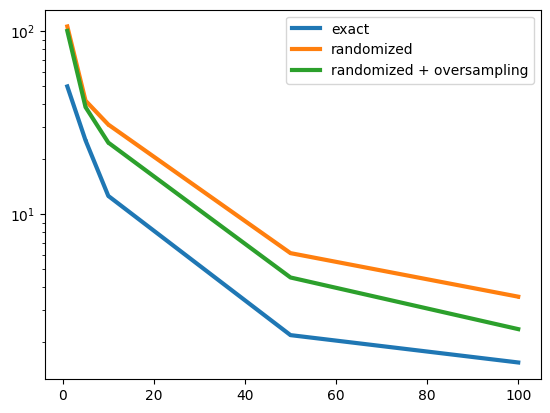

In [90]:
plt.semilogy(ks, reconstruction_error, "o-", label="exact", linewidth=3, markersize=1)
plt.semilogy(
    ks, reconstruction_error_rand, "o-", label="randomized", linewidth=3, markersize=1
)
plt.semilogy(
    ks,
    reconstruction_error_rand_oversampling,
    "o-",
    label="randomized + oversampling",
    linewidth=3,
    markersize=1,
)
plt.legend()

As we can see the exact SVD (blue line) is the best, as expected by the Eckart-Young theorem.

The randomized SVD (orange line) 

- 4: Make a scatterplot of the first two principal components of the patients (obtained with exact SVD), by plotting in red patients in the group ”cancer” and in blue the patients in the remaining group. 

    Repeat the same exercize with a rank k = 2 randomized SVD. 
    
    Compute the execution time needed to run the SVD algorithm in the two cases. Comment on the results.

(216, 216)


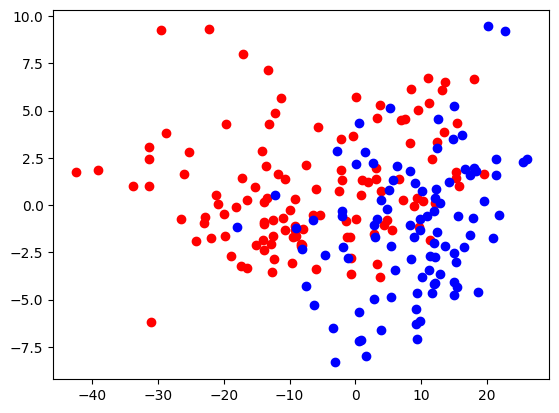

In [91]:
# Scatter plot of the first two principal components
U, s, VT = np.linalg.svd(A_bar, full_matrices=False)

PHI = U.T @ A_bar
print(PHI.shape)

plt.plot(
    PHI[0, grp == "Cancer"], PHI[1, grp == "Cancer"], "o", label="Cancer", color="red"
)
plt.plot(
    PHI[0, grp == "Normal"], PHI[1, grp == "Normal"], "o", label="Cancer", color="blue"
)

In [92]:
# # Scatter plot of the first two principal components
# A_barT = A_bar.T
# U, s, VT = np.linalg.svd(A_barT, full_matrices=False)
# print(A_barT.shape)

# PHI = A_barT @ VT.T
# print(PHI.shape)

# plt.plot(
#     PHI[grp == "Cancer", 0], PHI[grp == "Cancer", 1], "o", label="Cancer", color="red"
# )
# plt.plot(
#     PHI[grp == "Normal", 0], PHI[grp == "Normal", 1], "o", label="Cancer", color="blue"
# )

(2, 216)


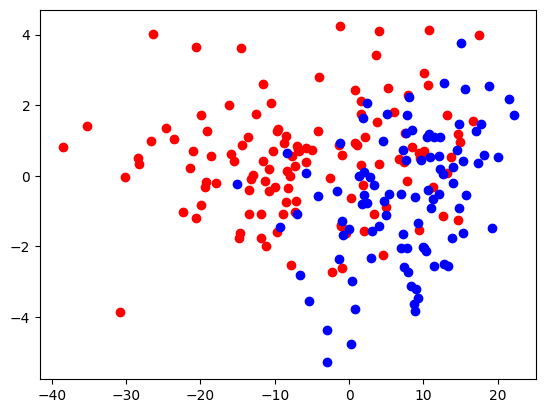

In [93]:
# Repeat the same with a rank 2 randomized SVD
k = 2
rU, rs, rVT = randomized_SVD(A_bar, k)

PHIk = rU.T @ A_bar
print(PHIk.shape)

plt.plot(
    PHIk[0, grp == "Cancer"], PHIk[1, grp == "Cancer"], "o", label="Cancer", color="red"
)
plt.plot(
    PHIk[0, grp == "Normal"],
    PHIk[1, grp == "Normal"],
    "o",
    label="Cancer",
    color="blue",
)

Execution time of the two algorithms:

In [94]:
import time

# exact SVD
t0 = time.time()
U, s, VT = np.linalg.svd(A_bar, full_matrices=False)
t1 = time.time()
print("Exact SVD took %f seconds" % (t1 - t0))

# randomized SVD
k = 2
t0 = time.time()
rU, rs, rVT = randomized_SVD(A_bar, k)
t1 = time.time()
print("Randomized SVD took %f seconds" % (t1 - t0))

Exact SVD took 0.139812 seconds
Randomized SVD took 0.005773 seconds


As we can see the randomized SVD result is different from the exact SVD result, but we still already see a separation between the two groups.

As expected, the randomized SVD is faster than the exact SVD.